In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import sparse_stoch_mat_central as sp_stoch_mat
import sys
from scipy.linalg import lu
from scipy.sparse.linalg import spsolve
import timeit
sys.path.append('/home/hcleroy/Extra_Module_py/')
from formated_matplotlib import *

## Equation differential of the problem :
$$ 
\begin{cases}
&\partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V_a] + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b = \partial_x^2 \rho_b +\partial_x[\rho_b \partial_x V_b] + \rho_a k_{ab} + \rho_c k_{cb} - \rho_b(k_{bc}+k_{ba})\\
&\partial_t \rho_c = \partial_x^2 \rho_c +\partial_x[\rho_c \partial_x V_c] + \rho_a k_{ac} + \rho_b k_{bc} - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = k_{ab}^0 e^{V_a+\epsilon_{ab}}A_{ab} \hspace{1cm} k_{bc} = k_{bc}^0e^{V_b+\epsilon_{bc}}A_{bc} \hspace{1cm} k_{ac} = k_{ac}^0 e^{V_a+\epsilon_{ac}}A_{ac}\\
&k_{ba} = k_{ab}^0 e^{V_b+\epsilon_{ab}} \hspace{1cm} k_{cb} = k_{bc}^0e^{V_c+\epsilon_{bc}} \hspace{1cm} k_{ca} = k_{ac}^0 e^{V_c+\epsilon_{ac}}
\end{cases}
$$
Where $V_a$, $V_b$, and $V_c$ are the space dependent potential that affect respectively $a$, $b$, $c$, $A_{ab}$, $A_{bc}$, $A_{ac}$ are respectively the activity brought to the reaction $a\rightarrow b$, $b\rightarrow c$, $a\rightarrow c$. the $k^0$ will define time units.

In [3]:
V0a, V0b, V0c = 1.,0.,0.#2.,2.6,4.
kab0,kbc0,kac0 = 1.,1.,1.
Aab,Abc,Aac = 1.,1.,1. # != 1 -> ooe
X0,Xf,n = -5,5,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx = '+str(dx))
Eab,Ebc,Eac = 0.,0.,0.
steep = 2.
# define all the Vs :
Va = lambda x : 0.5*(1+np.tanh(steep * x)) * V0a
dVa = lambda x : 0.5*steep/np.cosh(steep*x)**2 * V0a

Vb = lambda x : 0.5*(1+np.tanh(steep*x)) * V0b
dVb = lambda x : 0.5*steep/np.cosh(steep*x)**2 * V0b

Vc = lambda x : 0.5*(1+np.tanh(x*steep)) * V0c
dVc = lambda x : 0.5*steep/np.cosh(x*steep)**2 * V0c

# define all the k's
kab = lambda x,*arg : kab0 * np.exp(Va(x)+Eab)*arg[0] # arg is the activity
kba = lambda x,*arg : kab0 * np.exp(Vb(x)+Eab) # no activity but it takes the same argument as kab

kbc = lambda x,*arg : kbc0 * np.exp(Vb(x)+Ebc)*arg[0] # arg is the activity
kcb = lambda x,*arg : kbc0 * np.exp(Vc(x)+Ebc) # no activity but it takes the same argument as kbc

kac = lambda x,*arg : kac0 * np.exp(Va(x)+Eac)*arg[0] # arg is the activity
kca = lambda x,*arg : kac0 * np.exp(Vc(x)+Eac) # no activity but it takes the same argument as kac

def D(rho):
    """
    return the derivative of the density along space
    """
    drho = np.zeros(rho.shape[0],dtype=float)
    for i in range(1,rho.shape[0]-1):
        drho[i] = (rho[i+1]-rho[i-1])/(2*dx)
    drho[0] = 0.
    drho[-1] = 0.
    return drho
def DD(rho):
    """
    return the second derivative of the density along space
    """
    drho = np.zeros(rho.shape[0],dtype=float)
    for i in range(1,rho.shape[0]-1):
        drho[i] = (rho[i+1]+rho[i-1]-2*rho[i])/(dx)**2
    drho[0] = 0.
    drho[-1] = 0.
    return drho

dx = 0.001


## Discrete description of the system

We convert the spacial problem into a matrix problem by writting the derivative as finite difference using central difference scheme :
$$\partial_x\rho|_x = \frac{\rho((i+1)\delta x) - \rho((i-1) \delta x)}{2*\delta x}$$
$$\partial_x^2\rho|_x = \frac{\rho((i+2)\delta x) + \rho((i-2)\delta x) - 2\rho(i \delta x)}{(2*\delta x)^2}$$
We define :
$$\bar{\rho} = \{ \rho_a(x_0), \rho_a(x_0+\delta x), ... , \rho_a(x0 + i\delta x), ... , \rho_a(x_f), \rho_b(x_ 0), ... , \rho_b(x_f), \rho_c(x_0), ... , \rho_c(x_f)\}$$
which contains everything we need to know about the system. We can thus write the time evolution as :
$$\partial_t \bar{\rho} = M \bar{\rho}$$
Looking for the steady state solution, we just have to find the kernel of M. M is a stochastic matrix, thus has only one 0 eigenvalue.


In [4]:
Stoch_Mat = sp_stoch_mat.make_transition_matrix(Va,Vb,Vc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=1.,Abc=1.,Aac=1.,
                                    X0=X0,Xf=Xf,n=n)
Stoch_Mat_ooe = sp_stoch_mat.make_transition_matrix(Va,Vb,Vc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=Aab,Abc=Abc,Aac=Aac,
                                    X0=X0,Xf=Xf,n=n)

In [5]:
Stoch_Mat.shape

(30000, 30000)

Text(0, 0.5, 'sum of the transition')

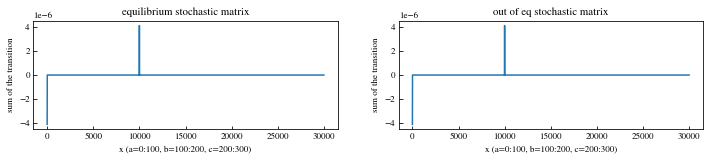

In [97]:
# check that the sum over the axis 0 is 0, because we have to have a stochastic matrix
fig,ax = plt.subplots(figsize = (12,2), ncols=2)
ax[0].plot(np.sum(Stoch_Mat,axis=0).A[0])
ax[0].set_xlabel('x (a=0:100, b=100:200, c=200:300)')
ax[0].set_ylabel('sum of the transition')
ax[0].set_title('equilibrium stochastic matrix')
ax[1].plot(np.sum(Stoch_Mat_ooe,axis=0).A[0])
ax[1].set_title('out of eq stochastic matrix')
ax[1].set_xlabel('x (a=0:100, b=100:200, c=200:300)')
ax[1].set_ylabel('sum of the transition')

## We use LU method to find the steady state
To find a vector from the kernel of a matrix using LU, we force the first value of the vector to be 1.

In [98]:
# use a reduced matrix (the first row and column is useless since the first value is fixed)
Omega1 = Stoch_Mat[1:,1:]
B = Stoch_Mat[1:,0]
start = timeit.default_timer()
x = spsolve(Omega1,-B)
print('time :' ,timeit.default_timer()-start)

# now add the first value as 1
rho_lu = np.zeros(x.shape[0]+1,dtype=float)
rho_lu[0] = 1
rho_lu [1:] = x
# normalize
rho_lu = abs(rho_lu)/(sum(abs(rho_lu))*dx)


rho_a_eq = np.real(rho_lu[:n])
rho_b_eq = np.real(rho_lu[n:2*n])
rho_c_eq = np.real(rho_lu[2*n:])

time : 0.025154205999569967


In [99]:
# use a reduced matrix (the first row and column is useless since the first value is fixed)
Omega1 = Stoch_Mat_ooe[1:,1:]
B = Stoch_Mat_ooe[1:,0]
start = timeit.default_timer()
x = spsolve(Omega1,-B)
print('time :' ,timeit.default_timer()-start)

# now add the first value as 1
rho_lu = np.zeros(x.shape[0]+1,dtype=float)
rho_lu[0] = 1
rho_lu [1:] = x
# normalize
rho_lu = abs(rho_lu)/(sum(abs(rho_lu))*dx)


rho_a_ooe = np.real(rho_lu[:n])
rho_b_ooe = np.real(rho_lu[n:2*n])
rho_c_ooe = np.real(rho_lu[2*n:])

time : 0.02352226699804305


v,w = la.eig(Stoch_Mat)
for i in range(v.shape[0]):
    w[:,i] = abs(w[:,i])/(sum(abs(w[:,i]))*dx)
v_ooe,w_ooe = la.eig(Stoch_Mat_cent)
for i in range(v_ooe.shape[0]):
    w_ooe[:,i] = abs(w_ooe[:,i])/(sum(abs(w_ooe[:,i]))*dx)


rho_a_ooe = np.real(w_ooe[:,np.argsort(v_ooe)[-1]][:n])
rho_b_ooe = np.real(w_ooe[:,np.argsort(v_ooe)[-1]][n:2*n])
rho_c_ooe = np.real(w_ooe[:,np.argsort(v_ooe)[-1]][2*n:3*n])

rho_a_eq = np.real(w[:,np.argsort(v)[-1]][:n])
rho_b_eq = np.real(w[:,np.argsort(v)[-1]][n:2*n])
rho_c_eq = np.real(w[:,np.argsort(v)[-1]][2*n:3*n])

In [100]:
print(sum(rho_a_eq)*dx+sum(rho_b_eq)*dx+sum(rho_c_eq)*dx)
print(sum(rho_a_ooe)*dx+sum(rho_b_ooe)*dx+sum(rho_c_ooe)*dx)

0.9999999999999992
0.9999999999999992


We check the compatibility between the equilibrium solution (from the matrix) and the one given by equilibrium statistical mechanics. Equilibrium stat-mech gives :
$$
\begin{aligned}
&P_a^\text{eq}(x) = \frac{e^{V_a(x)}}{Z} \\
&P_b^\text{eq}(x) = \frac{e^{V_b(x)}}{Z} \\
&P_c^\text{eq}(x) = \frac{e^{V_c(x)}}{Z} \\
\end{aligned}
$$
with $Z$ given by the normalisation condition :
$$
Z = \int_{X0}^{Xf}P_a^\text{eq}(x)+P_b^\text{eq}(x)+P_c^\text{eq}(x) \text{d}x
$$

In [105]:
def make_eq_distrib(Va,Vb,Vc,x):
    rho_a,rho_b,rho_c = np.exp(-Va(x)),np.exp(-Vb(x)),np.exp(-Vc(x))
    Z = (sum(rho_a)+sum(rho_b)+sum(rho_c))*dx
    res = np.zeros(3*n,dtype=float)
    return rho_a/Z,rho_b/Z,rho_c/Z
def make_chem_eq(kab,kba,kac,kca,kbc,kcb,Aab,Aac,Abc,x):
    rho_a = kca(x,Abc)*kba(x)+kba(x)*kca(x)+kbc(x,Abc)*kca(x)
    rho_b = kab(x,Aab)*kcb(x)+kca(x)*kab(x,Aab)+kac(x,Aac)*kcb(x)
    rho_c = kbc(x,Abc)*kac(x,Aac)+kba(x)*kac(x,Aac)+kab(x,Aab)*kbc(x,Abc)
    S = rho_a+rho_b+rho_c
    return rho_a/S,rho_b/S,rho_c/S

In [106]:
rho_a_stat_mech, rho_b_stat_mech,rho_c_stat_mech = make_eq_distrib(Va,Vb,Vc,np.linspace(X0,Xf,n,endpoint=False))
rho_a_chem,rho_b_chem,rho_c_chem = make_chem_eq(kab,kba,kac,kca,kbc,kcb,Aab=1,Aac=1.,Abc=1.,x=np.linspace(X0,Xf,n,endpoint=False))

Text(0, 0.5, 'Va')

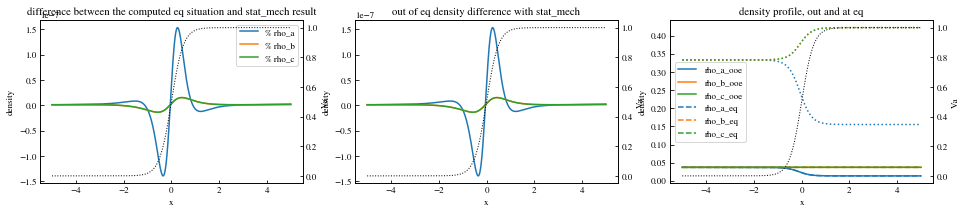

In [107]:
fig,ax = plt.subplots(figsize=(16,3),ncols=3)
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_eq,linestyle='--')
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),rho_b_eq,linestyle='--')
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_eq,linestyle='--',label='matrix solution')

#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_stat_mech)
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),rho_b_stat_mech)
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_stat_mech,label='stat mech')

ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),(rho_a_eq-rho_a_stat_mech)/(rho_a_eq+rho_a_stat_mech),label='% rho_a')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),(rho_b_eq-rho_b_stat_mech)/(rho_b_eq+rho_b_stat_mech),label='% rho_b')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),(rho_c_eq-rho_c_stat_mech)/(rho_c_eq+rho_c_stat_mech),label='% rho_c')

ax[0].set_title('difference between the computed eq situation and stat_mech result')
ax[0].set_xlabel('x')
ax[0].set_ylabel('density')
ax[0].legend()
ax1 = ax[0].twinx()
ax1.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=1,linestyle=':')
ax1.set_ylabel('Va')

ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),(rho_a_ooe-rho_a_stat_mech)/(rho_a_ooe+rho_a_stat_mech),label='% rho_a')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),(rho_b_ooe-rho_b_stat_mech)/(rho_b_ooe+rho_b_stat_mech),label='% rho_b')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),(rho_c_ooe-rho_c_stat_mech)/(rho_c_ooe+rho_c_stat_mech),label='% rho_c')
ax[1].set_title('out of eq density difference with stat_mech')
ax[1].set_xlabel('x')
ax[1].set_ylabel('density')
ax2 = ax[1].twinx()
ax2.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=1,linestyle=':')
ax2.set_ylabel('Va')

ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_ooe,color=ColorCycle[0],label='rho_a_ooe')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_b_ooe,color=ColorCycle[1],label='rho_b_ooe')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_ooe,color=ColorCycle[2],label='rho_c_ooe')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_eq,color=ColorCycle[0],linestyle='--',label='rho_a_eq')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_eq,color=ColorCycle[1],linestyle='--',label='rho_b_eq')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_eq,color=ColorCycle[2],linestyle='--',label='rho_c_eq')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_chem,color=ColorCycle[0],linestyle=':')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_b_chem,color=ColorCycle[1],linestyle=':')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_chem,color=ColorCycle[2],linestyle=':')
ax[2].set_title('density profile, out and at eq')
ax[2].set_xlabel('x')
ax[2].set_ylabel('density')
ax[2].legend()
ax3 = ax[2].twinx()
ax3.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=1,linestyle=':')
ax3.set_ylabel('Va')

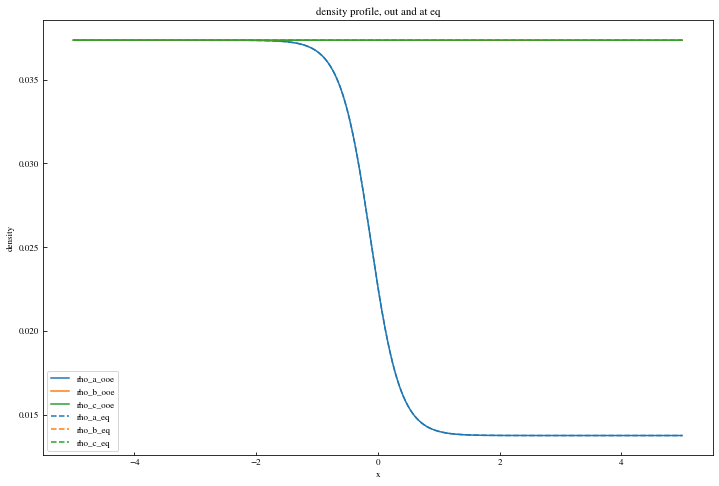

In [109]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_ooe,color=ColorCycle[0],label='rho_a_ooe')
plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_b_ooe,color=ColorCycle[1],label='rho_b_ooe')
plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_ooe,color=ColorCycle[2],label='rho_c_ooe')
plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_eq,color=ColorCycle[0],linestyle='--',label='rho_a_eq')
plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_eq,color=ColorCycle[1],linestyle='--',label='rho_b_eq')
plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_eq,color=ColorCycle[2],linestyle='--',label='rho_c_eq')
#plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_chem,color=ColorCycle[0],linestyle=':',label='a chem_eq')
#plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_b_chem,color=ColorCycle[1],linestyle=':',label='b chem_eq')
#plt.plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_chem,color=ColorCycle[2],linestyle=':',label='c chem_eq')
plt.title('density profile, out and at eq')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()

Text(0, 0.5, 'Va')

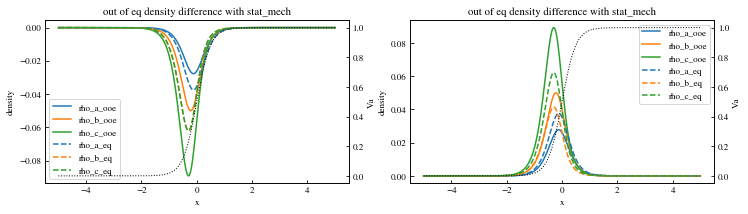

In [58]:


from numpy import linspace


rho_a_stat_mech, rho_b_stat_mech,rho_c_stat_mech = make_eq_distrib(Va,Vb,Vc,np.linspace(X0,Xf,n,endpoint=False))


fig,ax = plt.subplots(figsize=(12,3),ncols=2)


ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),D(rho_a_ooe),color=ColorCycle[0],label='rho_a_ooe')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),D(rho_b_ooe),color=ColorCycle[1],label='rho_b_ooe')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),D(rho_c_ooe),color=ColorCycle[2],label='rho_c_ooe')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),D(rho_a_eq),color=ColorCycle[0],linestyle='--',label='rho_a_eq')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),D(rho_c_eq),color=ColorCycle[1],linestyle='--',label='rho_b_eq')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),D(rho_c_eq),color=ColorCycle[2],linestyle='--',label='rho_c_eq')
ax[0].set_title('out of eq density difference with stat_mech')
ax[0].set_xlabel('x')
ax[0].set_ylabel('density')
ax[0].legend()
ax3 = ax[0].twinx()
ax3.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=1,linestyle=':')
ax3.set_ylabel('Va')

ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_ooe*dVa(linspace(X0,Xf,n,endpoint=False)),color=ColorCycle[0],label='rho_a_ooe')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),rho_b_ooe*dVb(linspace(X0,Xf,n,endpoint=False)),color=ColorCycle[1],label='rho_b_ooe')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_ooe*dVc(linspace(X0,Xf,n,endpoint=False)),color=ColorCycle[2],label='rho_c_ooe')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_eq*dVa(linspace(X0,Xf,n,endpoint=False)),color=ColorCycle[0],linestyle='--',label='rho_a_eq')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_eq*dVb(linspace(X0,Xf,n,endpoint=False)),color=ColorCycle[1],linestyle='--',label='rho_b_eq')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),rho_c_eq*dVc(linspace(X0,Xf,n,endpoint=False)),color=ColorCycle[2],linestyle='--',label='rho_c_eq')
ax[1].set_title('out of eq density difference with stat_mech')
ax[1].set_xlabel('x')
ax[1].set_ylabel('density')
ax[1].legend(loc=1)
ax3 = ax[1].twinx()
ax3.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=1,linestyle=':')
ax3.set_ylabel('Va')

## Computation of the fluxs

The chemical flux of each specie is defined as :
$$
\phi_i^\chi(x) = \sum_{j \neq i} k_{ji}(x)\rho_j(x) - \sum_{j\neq i}k_{ij}(x) \rho_i(x)
$$
On the other hand the diffusive flux gives:
$$
\phi_i^\text{diff}(x) = \partial_x^2 \rho_i +\partial_x[\rho_i \partial_x V_i]
$$
For each species we represent these fluxes as a vectorial field in the 2d plan where X is the space and Y is A/B.

In [51]:
# define the two fluxes :
def chem_flux(kjis,kijs,rho_i,rho_js,ix,x):
    """
    - kjis : is a vector of chemical transition from any j to the specie i
    - kijs : is a vector of chemical transition from the specie i to any j
    - rho_i : is the array of density in space of the specie i
    - rho_js : is the array of array of density in space of all the j's species
    - x : is the position in space
    - ix : is the corresponding index
    !!!!! the kjis, kijs, and rho_js must be sorted similarly
    """
    if rho_js.shape[0] != kjis.shape[0] or rho_js.shape[0] != kjis.shape[0] :
        raise IndexError
    return sum([kjis[j](x)*rho_js[j][ix]-kijs[j](x)*rho_i[ix] for j in range(rho_js.__len__())])
def diff_flux(rho,V):
    """"
    - rho_i : is the vector of density in space
    - dV : is a function dV(x) returns the derivative of the potential in x
    - x.dx is the position in space
    """
    dVx = D(V)
    return D(rho)+rho*dVx

Text(0, 0.5, 'Va')

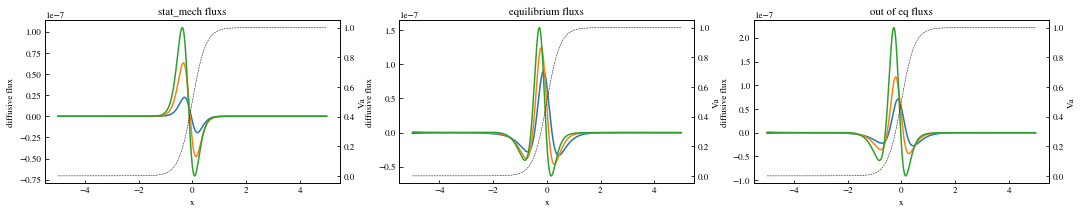

In [52]:
fig,ax = plt.subplots(figsize=(18,3),ncols=3)

ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_a_stat_mech,Va(np.linspace(X0,Xf,n,endpoint=False))),color=ColorCycle[0])
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_b_stat_mech,Vb(np.linspace(X0,Xf,n,endpoint=False))),color=ColorCycle[1])
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_c_stat_mech,Vc(np.linspace(X0,Xf,n,endpoint=False))),color=ColorCycle[2])
ax[0].set_xlabel('x')
ax[0].set_ylabel('diffusive flux')
ax[0].set_title('stat_mech fluxs')
ax1 = ax[0].twinx()
ax1.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=0.5,linestyle='--')
ax1.set_ylabel('Va')

ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_a_eq,Va(np.linspace(X0,Xf,n,endpoint=False))),color=ColorCycle[0])
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_b_eq,Vb(np.linspace(X0,Xf,n,endpoint=False))),color=ColorCycle[1])
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_c_eq,Vc(np.linspace(X0,Xf,n,endpoint=False))),color=ColorCycle[2])
ax[1].set_xlabel('x')
ax[1].set_ylabel('diffusive flux')
ax[1].set_title('equilibrium fluxs')
ax2 = ax[1].twinx()
ax2.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=0.5,linestyle='--')
ax2.set_ylabel('Va')

ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_a_ooe,Va(np.linspace(X0,Xf,n,endpoint=False))))
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_b_ooe,Vb(np.linspace(X0,Xf,n,endpoint=False))))
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),diff_flux(rho_c_ooe,Vc(np.linspace(X0,Xf,n,endpoint=False))))
ax[2].set_xlabel('x')
ax[2].set_ylabel('diffusive flux')
ax[2].set_title('out of eq fluxs')
ax3 = ax[2].twinx()
ax3.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=0.5,linestyle='--')
ax3.set_ylabel('Va')





# Chemical fluxes

In [113]:
#ab, ac ,bc 
kajs_eq = np.array([lambda x : kab(x,1.),lambda x : kac(x,1.)])
kjas_eq = np.array([kba,kca])

kbjs_eq = np.array([kba,lambda x : kbc(x,1.)])
kjbs_eq = np.array([lambda x : kab(x,1.),kcb])

kcjs_eq = np.array([kca,kcb])
kjcs_eq = np.array([lambda x : kac(x,1.),lambda x : kbc(x,1.)])

kajs_ooe = np.array([lambda x : kab(x,Aab),lambda x : kac(x,Aac)])
kjas_ooe = np.array([kba,kca])

kbjs_ooe = np.array([kba,lambda x : kbc(x,Abc)])
kjbs_ooe = np.array([lambda x : kab(x,Aab),kcb])

kcjs_ooe = np.array([kca,kcb])
kjcs_ooe = np.array([lambda x : kac(x,Aac),lambda x : kbc(x,Abc)])

rho_a_js_eq = np.array([rho_b_eq,rho_c_eq])
rho_b_js_eq = np.array([rho_a_eq,rho_c_eq])
rho_c_js_eq = np.array([rho_a_eq,rho_b_eq])

rho_a_js_stat_mech = np.array([rho_b_stat_mech,rho_c_stat_mech])
rho_b_js_stat_mech = np.array([rho_a_stat_mech,rho_c_stat_mech])
rho_c_js_stat_mech = np.array([rho_a_stat_mech,rho_b_stat_mech])

rho_a_js_chem = np.array([rho_b_chem,rho_c_chem])
rho_b_js_chem = np.array([rho_a_chem,rho_c_chem])
rho_c_js_chem = np.array([rho_a_chem,rho_b_chem])

rho_a_js_ooe = np.array([rho_b_ooe,rho_c_ooe])
rho_b_js_ooe = np.array([rho_a_ooe,rho_c_ooe])
rho_c_js_ooe = np.array([rho_a_ooe,rho_b_ooe])

A_Chem_flux_eq = np.array([chem_flux(kjas_eq,kajs_eq,rho_a_eq,rho_a_js_eq,i,X0+i*dx) for i in range(n)])
B_Chem_flux_eq = np.array([chem_flux(kjbs_eq,kbjs_eq,rho_b_eq,rho_b_js_eq,i,X0+i*dx) for i in range(n)])
C_Chem_flux_eq = np.array([chem_flux(kjcs_eq,kcjs_eq,rho_c_eq,rho_c_js_eq,i,X0+i*dx) for i in range(n)])

A_Chem_flux_stat_mech = np.array([chem_flux(kjas_eq,kajs_eq,rho_a_stat_mech,rho_a_js_stat_mech,i,X0+i*dx) for i in range(n)])
B_Chem_flux_stat_mech = np.array([chem_flux(kjbs_eq,kbjs_eq,rho_b_stat_mech,rho_b_js_stat_mech,i,X0+i*dx) for i in range(n)])
C_Chem_flux_stat_mech = np.array([chem_flux(kjcs_eq,kcjs_eq,rho_c_stat_mech,rho_c_js_stat_mech,i,X0+i*dx) for i in range(n)])

A_Chem_flux_ooe = np.array([chem_flux(kjas_ooe,kajs_ooe,rho_a_ooe,rho_a_js_ooe,i,X0+i*dx) for i in range(n)])
B_Chem_flux_ooe = np.array([chem_flux(kjbs_ooe,kbjs_ooe,rho_b_ooe,rho_b_js_ooe,i,X0+i*dx) for i in range(n)])
C_Chem_flux_ooe = np.array([chem_flux(kjcs_ooe,kcjs_ooe,rho_c_ooe,rho_c_js_ooe,i,X0+i*dx) for i in range(n)])

A_Chem_flux_chem_eq = np.array([chem_flux(kjas_eq,kajs_eq,rho_a_chem,rho_a_js_chem,i,X0+i*dx) for i in range(n)])
B_Chem_flux_chem_eq = np.array([chem_flux(kjbs_eq,kbjs_eq,rho_b_chem,rho_b_js_chem,i,X0+i*dx) for i in range(n)])
C_Chem_flux_chem_eq = np.array([chem_flux(kjcs_eq,kcjs_eq,rho_c_chem,rho_c_js_chem,i,X0+i*dx) for i in range(n)])

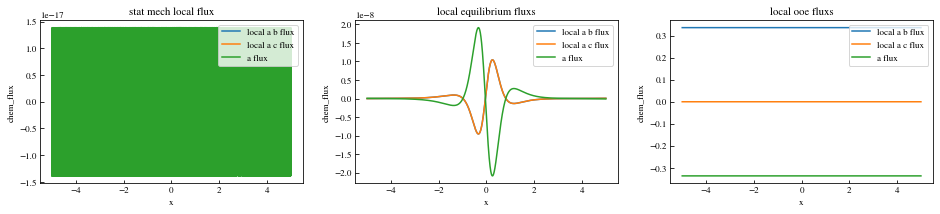

In [111]:
# local chem fluxes are : A->B and B->A

fig,ax = plt.subplots(figsize=(16,3),ncols=3)
# Stat mech checks that chem_flux are well computed
ab_flux = rho_a_stat_mech*np.array([kab(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_b_stat_mech*np.array([kba(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
ac_flux = rho_a_stat_mech*np.array([kac(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_c_stat_mech*np.array([kca(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
a_flux = np.array([chem_flux(np.array([kba,kca]),np.array([lambda x:kab(x,1.),lambda x:kac(x,1.)]),rho_a_stat_mech,np.array([rho_b_stat_mech,rho_c_stat_mech]),i,i*dx+X0) for i in range(n)])
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),ab_flux,label='local a b flux')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),ac_flux,label='local a c flux')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),a_flux, label='a flux')
ax[0].set_title('stat mech local flux')
ax[0].set_xlabel('x')
ax[0].set_ylabel('chem_flux')
ax[0].legend()

ab_flux = rho_a_eq*np.array([kab(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_b_eq*np.array([kba(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
ac_flux = rho_a_eq*np.array([kac(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_c_eq*np.array([kca(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
a_flux = np.array([chem_flux(np.array([kba,kca]),np.array([lambda x:kab(x,1.),lambda x:kac(x,1.)]),rho_a_eq,np.array([rho_b_eq,rho_c_eq]),i,i*dx+X0) for i in range(n)])
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),ab_flux,label='local a b flux')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),ac_flux,label='local a c flux')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),a_flux, label='a flux')
ax[1].set_title('local equilibrium fluxs')
ax[1].set_xlabel('x')
ax[1].set_ylabel('chem_flux')
ax[1].legend()

ab_flux = rho_a_ooe*np.array([kab(x,10.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_b_ooe*np.array([kba(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
ac_flux = rho_a_ooe*np.array([kac(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_c_ooe*np.array([kca(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
a_flux = np.array([chem_flux(np.array([kba,kca]),np.array([lambda x:kab(x,10.),lambda x:kac(x,1.)]),rho_a_ooe,np.array([rho_b_ooe,rho_c_ooe]),i,i*dx+X0) for i in range(n)])
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),ab_flux,label='local a b flux')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),ac_flux,label='local a c flux')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),a_flux, label='a flux')
ax[2].set_title('local ooe fluxs')
ax[2].set_xlabel('x')
ax[2].set_ylabel('chem_flux')
ax[2].legend()


Text(0, 0.5, 'Va')

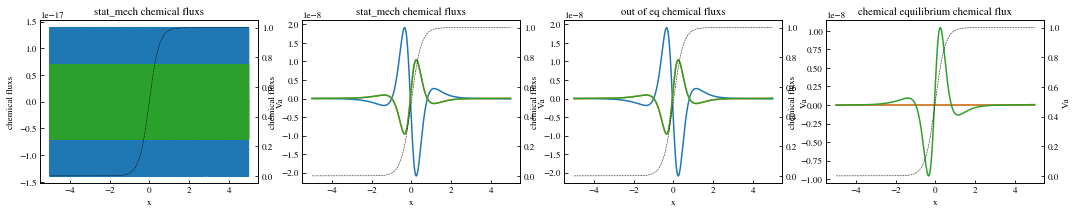

In [115]:
fig,ax = plt.subplots(figsize=(18,3),ncols=4)

ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),A_Chem_flux_stat_mech,color=ColorCycle[0])
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),B_Chem_flux_stat_mech,color=ColorCycle[1])
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),C_Chem_flux_stat_mech,color=ColorCycle[2])
ax[0].set_xlabel('x')
ax[0].set_ylabel('chemical fluxs')
ax[0].set_title('stat_mech chemical fluxs')
ax1 = ax[0].twinx()
ax1.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=0.5,linestyle='--')
ax1.set_ylabel('Va')

# kjis,kijs,rho_i,rho_js,x,dx
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),A_Chem_flux_eq,color=ColorCycle[0])
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),B_Chem_flux_eq,color=ColorCycle[1])
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),C_Chem_flux_eq,color=ColorCycle[2])
ax[1].set_xlabel('x')
ax[1].set_ylabel('chemical fluxs')
ax[1].set_title('stat_mech chemical fluxs')
ax2 = ax[1].twinx()
ax2.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=0.5,linestyle='--')
ax2.set_ylabel('Va')

ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),A_Chem_flux_ooe)
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),B_Chem_flux_ooe)
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),C_Chem_flux_ooe)
ax[2].set_xlabel('x')
ax[2].set_ylabel('chemical fluxs')
ax[2].set_title('out of eq chemical fluxs')
ax3 = ax[2].twinx()
ax3.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=0.5,linestyle='--')
ax3.set_ylabel('Va')

ax[3].plot(np.linspace(X0,Xf,n,endpoint=False),A_Chem_flux_chem_eq)
ax[3].plot(np.linspace(X0,Xf,n,endpoint=False),B_Chem_flux_chem_eq)
ax[3].plot(np.linspace(X0,Xf,n,endpoint=False),C_Chem_flux_eq)
ax[3].set_xlabel('x')
ax[3].set_ylabel('chemical fluxs')
ax[3].set_title('chemical equilibrium chemical flux')
ax3 = ax[3].twinx()
ax3.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black',linewidth=0.5,linestyle='--')
ax3.set_ylabel('Va')
